# Zu welchem Genre gehört das Filmposter

Ablauf:

1. Importieren von allen Bibliotheken
2. Einlesen der csv Datei
3. Datenbereinigung
4. Herunterladen der Bilder
5. Input Pipeline erstellen
6. Ki Model bauen
7. Model trainieren und evaluieren
8. Exportieren & sichern des Models

In [31]:
import logging
import os
import warnings

import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
import shutil
import multiprocessing
import urllib.error
import urllib.request

from joblib import Parallel, delayed
from time import time


from datetime import datetime
from keras.preprocessing import image
from PIL import Image
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from tensorflow.keras import layers

warnings.filterwarnings('ignore')
logging.getLogger("tensorflow").setLevel(logging.ERROR)

## Laden der Daten

In [32]:
movie_data = pd.read_csv("./data/MovieGenre.csv",
                          sep=",", encoding='unicode_escape', index_col=None)
movie_data.head()

,imdbId,Imdb Link,Title,IMDB Score,Genre,Poster
0,114709,http://www.imdb.com/title/tt114709,Toy Story (1995),8.3,Animation|Adventure|Comedy,https://images-na.ssl-images-amazon.com/images...
1,113497,http://www.imdb.com/title/tt113497,Jumanji (1995),6.9,Action|Adventure|Family,https://images-na.ssl-images-amazon.com/images...
2,113228,http://www.imdb.com/title/tt113228,Grumpier Old Men (1995),6.6,Comedy|Romance,https://images-na.ssl-images-amazon.com/images...
3,114885,http://www.imdb.com/title/tt114885,Waiting to Exhale (1995),5.7,Comedy|Drama|Romance,https://images-na.ssl-images-amazon.com/images...
4,113041,http://www.imdb.com/title/tt113041,Father of the Bride Part II (1995),5.9,Comedy|Family|Romance,https://images-na.ssl-images-amazon.com/images...


## Datenbereinigung

In [33]:
# Entfernen von Null Werten
movie_data.dropna(subset=['imdbId', 'Genre', 'Poster'], inplace=True)

### Herunterladen der Daten (Parallel)

In [34]:
def download_parallel(movies, image_dir):
    # Create list of filenames
    filenames = movies['imdbId'].apply(lambda imbdId : os.path.join(image_dir, str(imbdId)+'.jpg'))
    # Create list of image urls
    urls = movies['Poster']

    # Create destination directory
    if os.path.exists(image_dir):
        print("Directory '{}' already exists and will be deleted.".format(image_dir))
        shutil.rmtree(image_dir)
    print("Created new directory '{}'".format(image_dir))
    os.makedirs(image_dir)

    # Define function to download one single image
    def download_image(url, filename):
        try:
            urllib.request.urlretrieve(url, filename)
            return 0
        except:
            return os.path.basename(filename).split('.')[0]

    # Download images in parallel
    start = time()
    print("\nDownloading...")
    num_cores = multiprocessing.cpu_count()
    ko_list = Parallel(n_jobs=num_cores)(delayed(download_image)(u, f) for f, u in zip(filenames, urls))

    print("\nDownload in parallel mode took %d seconds." %(time()-start))
    print("Success:", len([i for i in ko_list if i==0]))
    print("Errors:", len([i for i in ko_list if i!=0]))

    # Remove not downloaded posters from the dataframe
    print("length of Movies before removing errors: " + str(len(movies)))
    imdbIdToBeRemoved = []
    for item in ko_list:
        if(item !=0):
            imdbIdToBeRemoved.append(item)
    movies= movies[~ movies["imdbId"].astype(str).isin(imdbIdToBeRemoved)]
    print("length of Movies after removing errors: " + str(len(movies)))

    return movies


destination = './data/movie-posters'
movie_data = download_parallel(movie_data, destination)

Directory './data/movie-posters' already exists and will be deleted.
Created new directory './data/movie-posters'

Downloading...

Download in parallel mode took 966 seconds.
Success: 36343
Errors: 2920
length of Movies before removing errors: 39263
length of Movies after removing errors: 36343


In [35]:
data_dir = "./data"
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
movie_data.to_csv(os.path.join(data_dir, "movies.csv"), index=False)

In [59]:
movie_data = pd.read_csv("./data/movies.csv")
label_freq = movie_data['Genre'].apply(lambda s: str(s).split('|')).explode().value_counts().sort_values(ascending=False)
rare = list(label_freq[label_freq<1000].index)

print("Number of movie posters in last download: {}\n".format(len(movie_data)))
movie_data['Genre'] = movie_data['Genre'].apply(lambda s: [l for l in str(s).split('|') if l not in rare])
movie_data.head(3)

Number of movie posters in last download: 36343

Number of movie posters in last download: 36343



,imdbId,Imdb Link,Title,IMDB Score,Genre,Poster
0,114709,http://www.imdb.com/title/tt114709,Toy Story (1995),8.3,"[Animation, Adventure, Comedy]",https://images-na.ssl-images-amazon.com/images...
1,113497,http://www.imdb.com/title/tt113497,Jumanji (1995),6.9,"[Action, Adventure, Family]",https://images-na.ssl-images-amazon.com/images...
2,113228,http://www.imdb.com/title/tt113228,Grumpier Old Men (1995),6.6,"[Comedy, Romance]",https://images-na.ssl-images-amazon.com/images...


In [50]:

rare

['Short',
 'Western',
 'Musical',
 'Sport',
 'Film-Noir',
 'News',
 'Adult',
 'Talk-Show',
 'Reality-TV',
 'Game-Show']

## Input Pipeline erstellen

In [60]:
X_train, X_val, y_train, y_val = train_test_split(movie_data['imdbId'], movie_data['Genre'], test_size=0.2, random_state=44)
print("Number of posters for training: ", len(X_train))
print("Number of posters for validation: ", len(X_val))

# we need files instead of imdbIds
X_train = [os.path.join('./data/movie-posters/', str(f)+'.jpg') for f in X_train]
X_val = [os.path.join('./data/movie-posters/', str(f)+'.jpg') for f in X_val]
print(X_train[:3])
print(X_val[:3])

y_train = list(y_train)
y_val = list(y_val)
print(y_train[:3])

Number of posters for training:  29074
Number of posters for validation:  7269
['./data/movie-posters/67227.jpg', './data/movie-posters/410520.jpg', './data/movie-posters/416938.jpg']
['./data/movie-posters/1831611.jpg', './data/movie-posters/1029120.jpg', './data/movie-posters/3091552.jpg']
[['Drama'], ['Documentary', 'Music'], ['Animation', 'Comedy']]


Beispiel Bilder

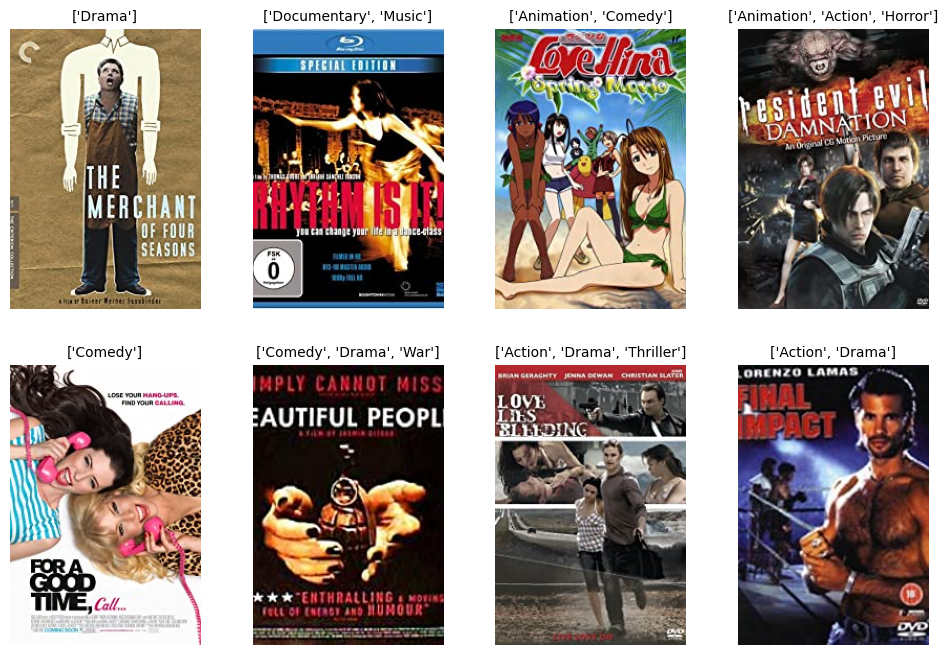

In [61]:
nobs = 8 # Maximum number of images to display
ncols = 4 # Number of columns in display
nrows = nobs//ncols # Number of rows in display

style.use("default")
plt.figure(figsize=(12,4*nrows))
for i in range(nrows*ncols):
    ax = plt.subplot(nrows, ncols, i+1)
    plt.imshow(Image.open(X_train[i]))
    plt.title(y_train[i], size=10)
    plt.axis('off')

 Label encoding

In [62]:
# Fit the multi-label binarizer on the training set
print("Labels:")
mlb = MultiLabelBinarizer()
mlb.fit(y_train)

# Loop over all labels and show them
N_LABELS = len(mlb.classes_)
for (i, label) in enumerate(mlb.classes_):
    print("{}. {}".format(i, label))

# transform the targets of the training and test sets
y_train_bin = mlb.transform(y_train)
y_val_bin = mlb.transform(y_val)

# Print example of movie posters and their binary targets
for i in range(3):
    print(X_train[i], y_train_bin[i])


Labels:
0. Action
1. Adventure
2. Animation
3. Biography
4. Comedy
5. Crime
6. Documentary
7. Drama
8. Family
9. Fantasy
10. History
11. Horror
12. Music
13. Mystery
14. Romance
15. Sci-Fi
16. Thriller
17. War
./data/movie-posters/67227.jpg [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
./data/movie-posters/410520.jpg [0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0]
./data/movie-posters/416938.jpg [0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]


## Pipeline

In [90]:
IMG_SIZE = 150 # Height and Width of an Image
CHANNELS = 3 # 3 Stands for RGB

BATCH_SIZE = 100 # Number of learning repetitions
SHUFFLE_BUFFER_SIZE = 1024 # Shuffle the training data by a chunck of 1024 observations
AUTOTUNE = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically


def parse_function(filename, label):
    # Read an image from a file
    image_string = tf.io.read_file(filename)
    # Decode it into a dense vector
    image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS)
    # Resize it to fixed shape
    image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
    # Normalize it from [0, 255] to [0.0, 1.0]
    image_normalized = image_resized / 255.0
    return image_normalized, label

def create_dataset(filenames, labels, is_training=True):
    # Create a first dataset of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Parse and preprocess observations in parallel
    dataset = dataset.map(parse_function, num_parallel_calls=AUTOTUNE)

    if is_training == True:
        # This is a small dataset, only load it once, and keep it in memory.
        dataset = dataset.cache()
        # Shuffle the data each buffer size
        dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)

    # Batch the data for multiple steps
    dataset = dataset.batch(BATCH_SIZE)
    # Fetch batches in the background while the model is training.
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)

    return dataset

train_ds = create_dataset(X_train, y_train_bin)
val_ds = create_dataset(X_val, y_val_bin)

for f, l in train_ds.take(1):
    print("Shape of features array:", f.numpy().shape)
    print("Shape of labels array:", l.numpy().shape)

Shape of features array: (100, 100, 100, 3)
Shape of labels array: (100, 18)


2022-05-28 17:57:42.640454: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


## Model bauen

In [91]:
model = tf.keras.Sequential()
inputShape = (IMG_SIZE, IMG_SIZE, 3)

model.add(layers.Conv2D(16, (5, 5), padding="same", activation="relu", input_shape=inputShape))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(layers.Conv2D(32, (5, 5), activation="relu", padding="same"))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(layers.Conv2D(32, (5, 5), activation="relu", padding="same"))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(layers.Conv2D(64, (5, 5), padding="same", activation="relu", name='last_conv_layer'))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation="relu"))
model.add(layers.Dropout(0.4))
model.add(layers.BatchNormalization())
model.add(layers.Dense(N_LABELS, activation="sigmoid"))

model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_55 (Conv2D)          (None, 100, 100, 16)      1216      
                                                                 
 max_pooling2d_64 (MaxPoolin  (None, 50, 50, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_56 (Conv2D)          (None, 50, 50, 32)        12832     
                                                                 
 max_pooling2d_65 (MaxPoolin  (None, 25, 25, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_57 (Conv2D)          (None, 25, 25, 32)        25632     
                                                                 
 max_pooling2d_66 (MaxPoolin  (None, 12, 12, 32)     

# Train

In [92]:
optimizer = tf.keras.adam(2e-4)
loss = tf.keras.metrics.binary_crossentropy

model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=["accuracy"])

EPOCHS = 150
start = time()
history = model.fit(train_ds,epochs=EPOCHS,validation_data=create_dataset(X_val, y_val_bin))

Epoch 1/150
291/291 [==============================] - 226s 774ms/step - loss: 0.3119 - accuracy: 0.2658 - val_loss: 0.2946 - val_accuracy: 0.3171
Epoch 2/150
291/291 [==============================] - 206s 708ms/step - loss: 0.2991 - accuracy: 0.2922 - val_loss: 0.2947 - val_accuracy: 0.3152
Epoch 3/150
291/291 [==============================] - 204s 701ms/step - loss: 0.2950 - accuracy: 0.3048 - val_loss: 0.2891 - val_accuracy: 0.3033
Epoch 4/150
291/291 [==============================] - 202s 695ms/step - loss: 0.2923 - accuracy: 0.3100 - val_loss: 0.2875 - val_accuracy: 0.3245
Epoch 5/150
291/291 [==============================] - 201s 692ms/step - loss: 0.2888 - accuracy: 0.3187 - val_loss: 0.2855 - val_accuracy: 0.3266
Epoch 6/150
291/291 [==============================] - 202s 695ms/step - loss: 0.2856 - accuracy: 0.3257 - val_loss: 0.2857 - val_accuracy: 0.3454
Epoch 7/150
291/291 [==============================] - 200s 688ms/step - loss: 0.2825 - accuracy: 0.3334 - val_loss: 0

KeyboardInterrupt: 

# Plot to see how good our KI is

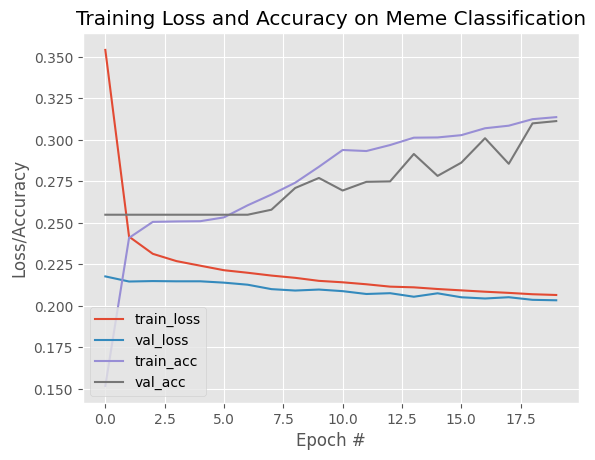

In [46]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, EPOCHS), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, EPOCHS), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, EPOCHS), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, EPOCHS), history.history["val_accuracy"], label="val_acc")

plt.title("Training Loss and Accuracy on Meme Classification")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("./data/models/plotsmaller1000")


# Save model

In [47]:
model_dir = "./data/models"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
model.save(model_dir+"/modelwithoutgenressmaller1000.h5",save_format="h5")